In [ ]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Reshape, Conv2DTranspose

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
from glob import glob
from tensorflow.keras.preprocessing import image

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d hyperclaw79/fakefaces

100% 5.32G/5.33G [00:50<00:00, 138MB/s]
100% 5.33G/5.33G [00:50<00:00, 112MB/s]


In [ ]:
!unzip -qq fakefaces.zip

In [ ]:
!mkdir './train'
!mv ./*.jpg ./train/

In [ ]:
files = glob('./train/*')

df= pd.DataFrame({'filename':files})

In [ ]:
df.head()

,filename
0,./train/1629.jpg
1,./train/1874.jpg
2,./train/6226.jpg
3,./train/5040.jpg
4,./train/2642.jpg


In [ ]:
train_path="./train"

IMAGE_SIZE=[64, 64]

image_files=glob(train_path+"/*.jpg")

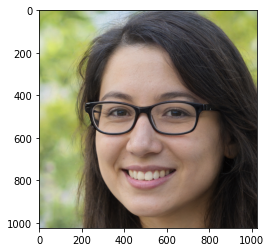

In [ ]:
plt.imshow(image.load_img(np.random.choice(image_files)))

In [ ]:
N,H,W = df.shape[0],IMAGE_SIZE[0],IMAGE_SIZE[1]
D=H*W
N,H,W,D

(6400, 64, 64, 4096)

In [ ]:
latent_dim = 500

In [ ]:
T = 16

In [ ]:
def build_generator(latent_dim):
  # weight initialization
	init = tf.keras.initializers.RandomNormal(stddev=0.02)
	# define model
	model = tf.keras.models.Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * T * T
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((T, T, 128)))
	# upsample to 14x14
	model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(LeakyReLU(alpha=0.2))
	# output 28x28x1
	model.add(Conv2D(3, (7,7), activation='tanh', padding='same', kernel_initializer=init))
	return model

In [ ]:
def build_discriminator(in_shape=(H,W,3)):
  # weight initialization
	init = tf.keras.initializers.RandomNormal(stddev=0.02)
	# define model
	model = tf.keras.models.Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = tf.keras.models.Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
discriminator = build_discriminator()
generator = build_generator(latent_dim)
combined_model = define_gan(generator,discriminator)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
batch_size=64
epochs=30000
sample_period=200

In [ ]:
ones=np.ones(batch_size)
zeros=np.zeros(batch_size)

d_losses=[]
g_losses=[]

if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [ ]:
def sample_images(epoch):
  rows, cols=5,5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)
  imgs=0.5 * imgs + 0.5
  
  fig, axs = plt.subplots(rows,cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W,3))
      axs[i,j].axis('off')
      idx += 1
  
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [ ]:
df_num=df.to_numpy()

In [ ]:
def get_batch(batch_size):
  ret = []
  idx = np.random.randint(0,df.shape[0],batch_size)
  real_imgs_name=df_num[idx,0]

  for f in real_imgs_name:
    img = np.array(image.load_img(f))
    img = tf.image.resize(img,[H,W])
    img = (img/255.0)*2-1
    ret.append(img)
  return np.array(ret)

In [ ]:
images_ = [ tf.image.resize(np.array(image.load_img(f)),[64,64]) for f in image_files]

In [ ]:
images_np = np.array(images_)
images_np=(images_np/255.0)*2-1

In [ ]:
for epoch in range(epochs):
  idx = np.random.randint(0,df.shape[0],batch_size)
  real_imgs=images_np[idx]

  noise=np.random.randn(batch_size,latent_dim)
  fake_imgs=generator.predict(noise)


  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs,ones)

  d_loss_fake,d_acc_fake = discriminator.train_on_batch(fake_imgs.reshape(batch_size,H,W,3),zeros)

  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  noise = np.random.randn(batch_size,latent_dim)
  g_loss = combined_model.train_on_batch(noise,ones)

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

  if epoch % sample_period == 0:
    sample_images(epoch)

epoch: 1/30000, d_loss: 0.69, d_acc: 0.45, g_loss: 0.69
epoch: 101/30000, d_loss: 0.89, d_acc: 0.52, g_loss: 1.08
epoch: 201/30000, d_loss: 0.56, d_acc: 0.73, g_loss: 1.34
epoch: 301/30000, d_loss: 0.70, d_acc: 0.52, g_loss: 1.05
epoch: 401/30000, d_loss: 0.67, d_acc: 0.59, g_loss: 0.82
epoch: 501/30000, d_loss: 0.69, d_acc: 0.48, g_loss: 0.80
epoch: 601/30000, d_loss: 0.68, d_acc: 0.59, g_loss: 0.75
epoch: 701/30000, d_loss: 0.70, d_acc: 0.47, g_loss: 0.81
epoch: 801/30000, d_loss: 0.66, d_acc: 0.67, g_loss: 0.78
epoch: 901/30000, d_loss: 0.69, d_acc: 0.55, g_loss: 0.79
epoch: 1001/30000, d_loss: 0.72, d_acc: 0.43, g_loss: 0.68
epoch: 1101/30000, d_loss: 0.69, d_acc: 0.52, g_loss: 0.73
epoch: 1201/30000, d_loss: 0.69, d_acc: 0.56, g_loss: 0.71
epoch: 1301/30000, d_loss: 0.69, d_acc: 0.55, g_loss: 0.74
epoch: 1401/30000, d_loss: 0.67, d_acc: 0.65, g_loss: 0.72
epoch: 1501/30000, d_loss: 0.69, d_acc: 0.48, g_loss: 0.70
epoch: 1601/30000, d_loss: 0.69, d_acc: 0.50, g_loss: 0.72
epoch: 17